In [1]:
import os
import json
import pandas as pd
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor as tt
from torchvision.utils import make_grid
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
!pip install torchsummary

In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001
ROOT_DIR = "/kaggle/input/bonemarrowdatasetprocessed-for-classification-task/data_processed/"

In [4]:
train_df = pd.read_csv(f"{ROOT_DIR}data/train.csv")
val_df = pd.read_csv(f"{ROOT_DIR}data/val.csv")
test_df = pd.read_csv(f"{ROOT_DIR}data/test.csv")

train_df.shape, val_df.shape, test_df.shape

((119961, 3), (16967, 3), (34446, 3))

In [5]:
class BMDataset():
    
    def __init__(self, dataframe, shape=(224, 224), system = "windows"):
        self.dataframe = dataframe
        self.shape = shape
        if system == "linux":
            self.dataframe["path"] = self.dataframe["path"].apply(self.process_path_on_linux)
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = os.path.join(ROOT_DIR, self.dataframe.iloc[idx, 0])
        label = self.dataframe.iloc[idx, 2]
        img = self._load_img(path)

        return img, label
    
    def process_path_on_linux(self, path):
        return "/".join(path.split("\\"))

    def _load_img(self, path):
        img = Image.open(path)
        img = img.resize(self.shape)
        img = tt()(img)
        return img


train_ds = BMDataset(train_df, system="linux")
val_ds = BMDataset(val_df,system="linux")
test_ds = BMDataset(test_df, system="linux")

In [6]:
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = False)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = False)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = False)

In [7]:
rand_train_batch_image, rand_train_batch_labels = next(iter(train_dl))
rand_train_batch_image.shape, rand_train_batch_labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [8]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import Resize

In [12]:
class BMBaseModel(nn.Module):

    def __init__(self, network, num_classes):
        super(BMBaseModel, self).__init__()
        if network == "resnet":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', "resnet18", pretrained=True)
        elif network == "inception":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', 'inception', pretrained=True)
        elif network == "googlenet":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
        #self.featurizer = self._freeze_layers(self.featurizer)
        self.mid_blocks = nn.Sequential(
                nn.Linear(1000, 2048),
                #nn.ReLU(),
                nn.Linear(2048, 1024),
                #nn.ReLU(),
                nn.Linear(1024, 256),
        )
        self.output_layer = nn.Linear(256, num_classes)

    def _freeze_layers(self, network):
        for param in network.parameters():
            param.requires_grad = False
        return network
    
    def forward(self, x):
        featurizer_op = self.featurizer(x)
        flattened_op = featurizer_op.view(featurizer_op.shape[0], -1)
        return self.output_layer(self.mid_blocks(flattened_op))

In [13]:
from torchsummary import summary

model = BMBaseModel("googlenet", 21)

summary(model, (3, 224, 224), batch_size=BATCH_SIZE, device="cpu")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
       BasicConv2d-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
       BasicConv2d-7          [128, 64, 56, 56]               0
            Conv2d-8         [128, 192, 56, 56]         110,592
       BatchNorm2d-9         [128, 192, 56, 56]             384
      BasicConv2d-10         [128, 192, 56, 56]               0
        MaxPool2d-11         [128, 192, 28, 28]               0
           Conv2d-12          [128, 64, 28, 28]          12,288
      BatchNorm2d-13          [128, 64, 28, 28]             128
      BasicConv2d-14          [128, 64,

In [14]:
chkp = torch.load(f"/kaggle/input/bonemarrowdatasetprocessed-for-classification-task/exp3_best.pt")
model.load_state_dict(chkp["model"])

<All keys matched successfully>

In [16]:
model.eval()
model = model.cuda()

In [17]:
def predict(model, dl):
    true = []
    pred = []
    for batch, labels in tqdm(dl):
        op = model(batch.cuda())
        true += labels.detach().numpy().tolist()
        pred += torch.argmax(op, dim=1).cpu().detach().numpy().tolist()
        del op, batch
    return true, pred

In [18]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

In [19]:
cols = ["ABE", "ART","BAS", "BLA", "EBO", "EOS", "FGC", "HAC", "KSC", "LYI", "LYT", "MMZ", "MON", "MYB", "NGB", "NGS", "NIF", "OTH", "PEB", "PLM", "PMO"]

100%|██████████| 938/938 [14:56<00:00,  1.05it/s]


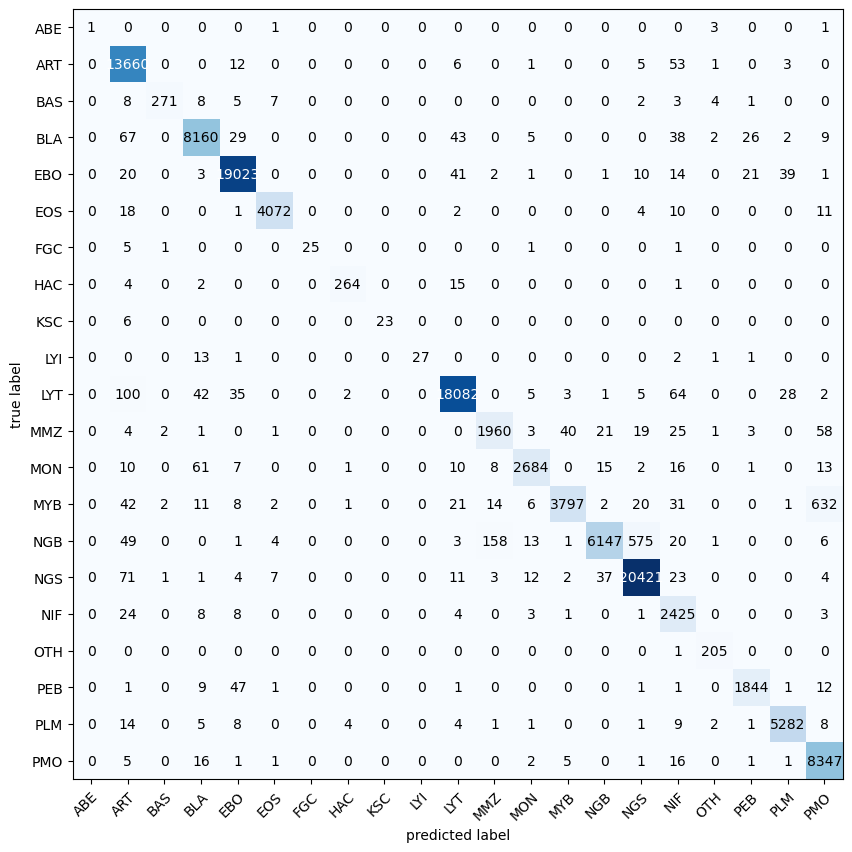

In [20]:
train_true, train_pred = predict(model, train_dl)
plot_confusion_matrix(confusion_matrix(train_true, train_pred), figsize=(10, 10), class_names=cols)
plt.savefig("train_conf_mat.png")

100%|██████████| 133/133 [02:09<00:00,  1.03it/s]


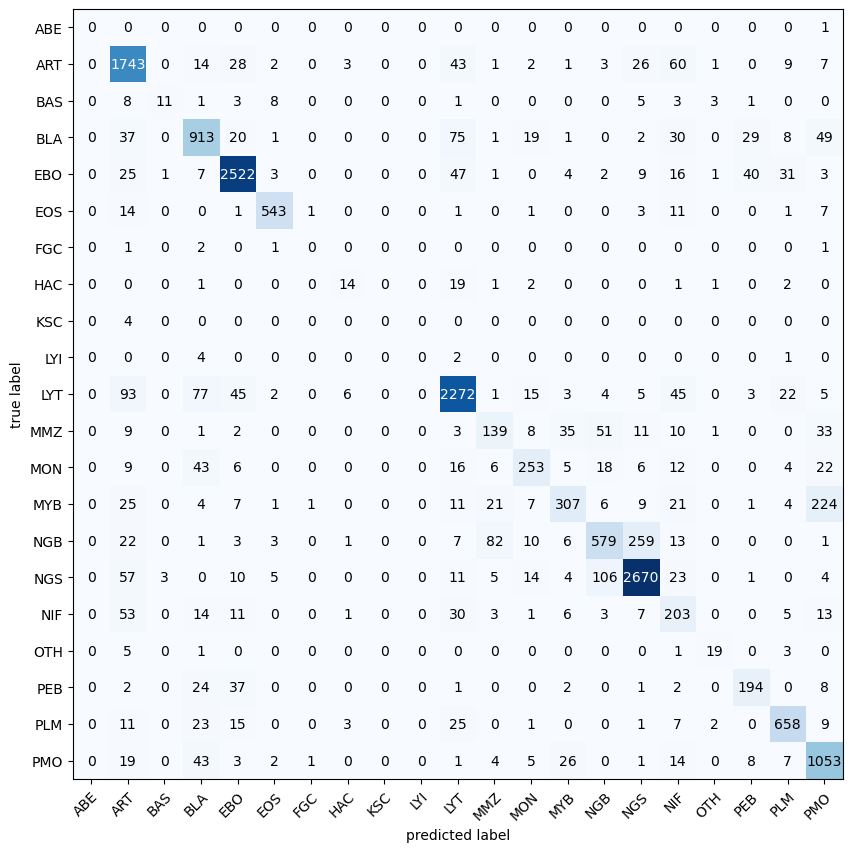

In [21]:
val_true, val_pred = predict(model, val_dl)
plot_confusion_matrix(confusion_matrix(val_true, val_pred), figsize=(10, 10), class_names=cols)
plt.savefig("val_conf_mat.png")

100%|██████████| 270/270 [04:29<00:00,  1.00it/s]


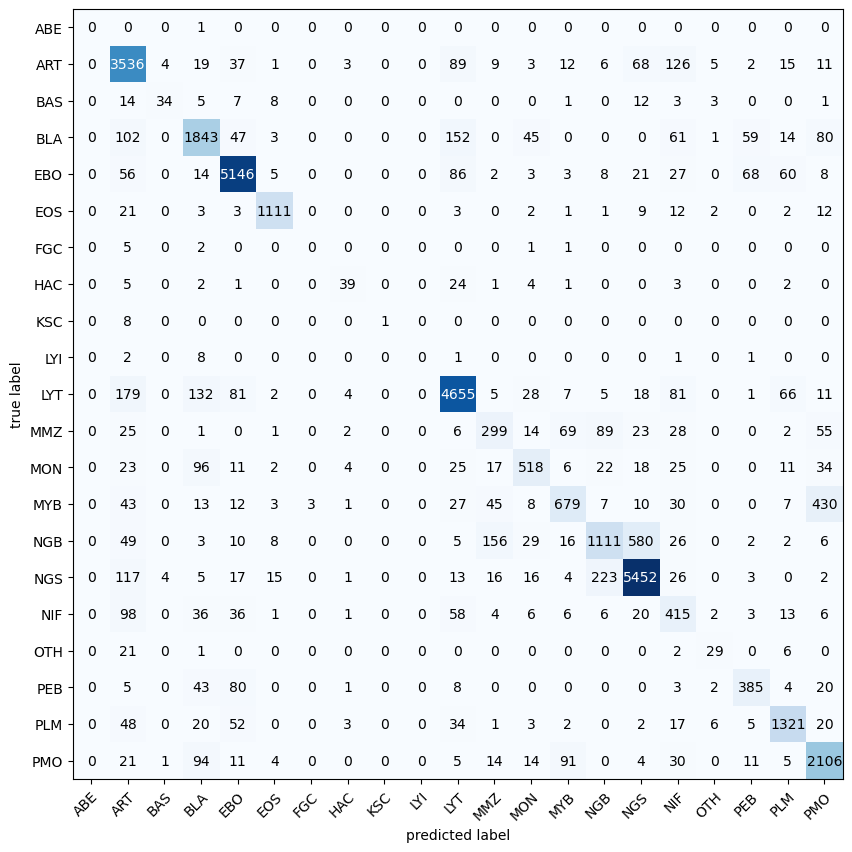

In [22]:
test_true, test_pred = predict(model, test_dl)
plot_confusion_matrix(confusion_matrix(test_true, test_pred), figsize=(10, 10), class_names=cols)
plt.savefig("test_conf_mat.png")

In [23]:
classification_report(train_true, train_pred)

'              precision    recall  f1-score   support\n\n           0       1.00      0.17      0.29         6\n           1       0.97      0.99      0.98     13741\n           2       0.98      0.88      0.92       309\n           3       0.98      0.97      0.98      8381\n           4       0.99      0.99      0.99     19176\n           5       0.99      0.99      0.99      4118\n           6       1.00      0.76      0.86        33\n           7       0.97      0.92      0.95       286\n           8       1.00      0.79      0.88        29\n           9       1.00      0.60      0.75        45\n          10       0.99      0.98      0.99     18369\n          11       0.91      0.92      0.92      2138\n          12       0.98      0.95      0.96      2828\n          13       0.99      0.83      0.90      4590\n          14       0.99      0.88      0.93      6978\n          15       0.97      0.99      0.98     20597\n          16       0.88      0.98      0.93      2477\n       

In [24]:
classification_report(val_true, val_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         1\n           1       0.82      0.90      0.85      1943\n           2       0.73      0.25      0.37        44\n           3       0.78      0.77      0.77      1185\n           4       0.93      0.93      0.93      2712\n           5       0.95      0.93      0.94       583\n           6       0.00      0.00      0.00         5\n           7       0.50      0.34      0.41        41\n           8       0.00      0.00      0.00         4\n           9       0.00      0.00      0.00         7\n          10       0.89      0.87      0.88      2598\n          11       0.52      0.46      0.49       303\n          12       0.75      0.63      0.69       400\n          13       0.77      0.47      0.59       649\n          14       0.75      0.59      0.66       987\n          15       0.89      0.92      0.90      2913\n          16       0.43      0.58      0.49       350\n       

In [25]:
classification_report(test_true, test_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         1\n           1       0.81      0.90      0.85      3946\n           2       0.79      0.39      0.52        88\n           3       0.79      0.77      0.78      2407\n           4       0.93      0.93      0.93      5507\n           5       0.95      0.94      0.95      1182\n           6       0.00      0.00      0.00         9\n           7       0.66      0.48      0.55        82\n           8       1.00      0.11      0.20         9\n           9       0.00      0.00      0.00        13\n          10       0.90      0.88      0.89      5275\n          11       0.53      0.49      0.51       614\n          12       0.75      0.64      0.69       812\n          13       0.76      0.52      0.61      1318\n          14       0.75      0.55      0.64      2003\n          15       0.87      0.92      0.90      5914\n          16       0.45      0.58      0.51       711\n       

           precision    recall  f1-score   support
0               1.00      0.17      0.29         6
1               0.97      0.99      0.98     13741
2               0.98      0.88      0.92       309
3               0.98      0.97      0.98      8381
4               0.99      0.99      0.99     19176
5               0.99      0.99      0.99      4118
6               1.00      0.76      0.86        3
7               0.97      0.92      0.95       286
8               1.00      0.79      0.88        29
9               1.00      0.60      0.75        45
10              0.99      0.98      0.99     18369
11              0.91      0.92      0.92      2138
12              0.98      0.95      0.96      2828
13              0.99      0.83      0.90      4590
14              0.99      0.88      0.93      6978
15              0.97      0.99      0.98     20597
16              0.88      0.98      0.93      2477
17              0.93      1.00      0.96       206
18              0.97      0.96      0.97      1918
19              0.99      0.99      0.99      5340
20              0.92      0.99      0.95      8396
accuracy                            0.97    119961
macro avg       0.97     0.88       0.91    119961
weighted avg    0.97     0.97       0.97    119961


               precision    recall  f1-score   support
0                   0.00      0.00      0.00         1
1                   0.82      0.90      0.85      1943
2                   0.73      0.25      0.37        44
3                   0.78      0.77      0.77      1185
4                   0.93      0.93      0.93      2712
5                   0.95      0.93      0.94       583
6                   0.00      0.00      0.00         5
7                   0.50      0.34      0.41        41
8                   0.00      0.00      0.00         4
9                   0.00      0.00      0.00         7
10                  0.89      0.87      0.88      2598
11                  0.52      0.46      0.49       303
12                  0.75      0.63      0.69       400
13                  0.77      0.47      0.59       649
14                  0.75      0.59      0.66       987
15                  0.89      0.92      0.90      2913
16                  0.43      0.58      0.49       350
17                  0.68      0.66      0.67        29
18                  0.70      0.72      0.71       271
19                  0.87      0.87      0.87       755
20                  0.73      0.89      0.80      1187
accuracy                                0.83     16967
macro avg           0.60      0.56      0.57     16967
weighted avg        0.83      0.83      0.83     16967

               precision    recall  f1-score   support
0                   0.00      0.00      0.00         1
1                   0.81      0.90      0.85      3946
2                   0.79      0.39      0.52        88
3                   0.79      0.77      0.78      2407
4                   0.93      0.93      0.93      5507
5                   0.95      0.94      0.95      1182
6                   0.00      0.00      0.00         9
7                   0.66      0.48      0.55        82
8                   1.00      0.11      0.20         9
9                   0.00      0.00      0.00        13
10                  0.90      0.88      0.89      5275
11                  0.53      0.49      0.51       614
12                  0.75      0.64      0.69       812
13                  0.76      0.52      0.61      1318
14                  0.75      0.55      0.64      2003
15                  0.87      0.92      0.90      5914
16                  0.45      0.58      0.51       711
17                  0.58      0.49      0.53        59
18                  0.71      0.70      0.71       551
19                  0.86      0.86      0.86      1534
20                  0.75      0.87      0.81      2411
accuracy                                0.83     34446
macro avg           0.66      0.57      0.59     34446
weighted avg        0.83      0.83      0.83     34446